###### В данном Jupyter Notebook проводится подготовка валидационного сета

Пайплайн:

1. Скачивание данных HERG-central;
2. Стандартизация единиц измерения активности к herg каналам, удаление дубликатов;
3. Кластеризация соединений с помощью python-скрипта от PatWalter: https://github.com/PatWalters/kmeans Параметры: fp = morgan3, dim = 2048, clusters = 500;
4. Анализ разбиения выборки на кластеры;
5. Составление наиболее сбалансированного валидацинного датасета из соединений разных кластеров;
6. Сохранение подготовленных данных в .csv файлы.

# Обработка данных с HERG-central

In [2]:
import logging
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean, std, zeros
from pandas import DataFrame
import pandas as pd
from pathlib import Path
import sys
from rdkit import Chem, DataStructs, RDConfig
from rdkit.Chem import AllChem, Descriptors, Draw, PandasTools, MolStandardize, DataStructs, ChemicalFeatures
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from IPython.display import display, display_png
import rdkit.rdBase as rkrb
import rdkit.RDLogger as rkl
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
from rdkit.Chem.Pharm2D import Generate
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegressionCV, LinearRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.datasets import make_classification 
from tqdm import tqdm
import xgboost
from xgboost import XGBRFClassifier
#import time

In [3]:
#! pip install tqdm

Загрузим датасет

In [4]:
df = pd.read_csv('herg_central.txt', delimiter = "\t")

In [5]:
df.isna().sum()

SMILES                         0
PubChem Substance ID           0
hERG inhibition (%) at 1uM     0
hERG inhibition (%) at 10uM    0
dtype: int64

In [6]:
len(df)

306895

In [7]:
df = df.drop_duplicates(subset ="PubChem Substance ID")
df

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM
0,C1=CC2=NC3=C(C=C(C(=NC(=O)C4=CC=CO4)N3CC5=CC=C...,22403712,-10.1124,-32.88202
1,C1C(CN(C1C(=O)OCC(=O)C2=CC=CC=C2Cl)S(=O)(=O)C3...,22411435,5.5191,4.12648
2,C1COCCN1C(=O)OC2=CC3=C(C=C2)C(=O)/C(=C/C4=CC=C...,17513249,9.5532,5.23978
3,CC1=NC2=CC=CC=C2C(=C1)C(=O)N/N=C/C3=CC(=CC=C3)...,17512209,-0.2112,-5.44332
4,COCCNC(=O)C1=C(N(C2=NC3=CC=CC=C3N=C12)CC4=CC=C...,14729741,12.6230,14.73378
...,...,...,...,...
306890,C1CCN(C1)S(=O)(=O)C2=CC=C(C=C2)C(=O)OCC(=O)NC3...,57262925,4.8576,1.38128
306891,C1CN(CCN1CC(=O)NC2=CC=C(C=C2)C(=O)N)S(=O)(=O)C...,57264745,4.4922,-3.78132
306892,CC1=CC(=C(C(=C1C)S(=O)(=O)N2CCN(CC2)C(=O)CNC(=...,57259638,-0.9701,-13.56112
306893,C1COCCN1C2=C(C=C(C=C2)C(F)(F)F)NC(=O)COC(=O)C3...,57261004,-7.1374,-25.02142


Удалим агонисты

In [8]:
df = df[df['hERG inhibition (%) at 10uM'] > 0]

In [9]:
df

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM
1,C1C(CN(C1C(=O)OCC(=O)C2=CC=CC=C2Cl)S(=O)(=O)C3...,22411435,5.5191,4.12648
2,C1COCCN1C(=O)OC2=CC3=C(C=C2)C(=O)/C(=C/C4=CC=C...,17513249,9.5532,5.23978
4,COCCNC(=O)C1=C(N(C2=NC3=CC=CC=C3N=C12)CC4=CC=C...,14729741,12.6230,14.73378
5,CC1CC(NC(=S)N1CC(=O)NCC2=CC=CC=C2Cl)(C)C,17511100,13.9004,13.68218
6,COC1=C(C=C(C=C1)C(=O)NC(=S)NC2=CC=C(C=C2)N3CCC...,17508525,11.3456,12.12248
...,...,...,...,...
306884,C1CCC(C1)NC(=O)CN2C(=O)C(NC2=O)(C3=CC=CC=C3)C4...,57260907,11.2146,4.94638
306885,CC1=CC(=C(C=C1)C)C(=O)CN2C(=O)C(=O)N(C2=O)C3CCCC3,57261825,6.1096,1.63218
306888,CC1=C(C=C(C=C1)OCC(=O)OCC(=O)NC2CC2)C,57262798,2.9471,4.09278
306890,C1CCN(C1)S(=O)(=O)C2=CC=C(C=C2)C(=O)OCC(=O)NC3...,57262925,4.8576,1.38128


Удалим соли

In [10]:
df = df.drop(df[df.SMILES.str.contains(r'[.]')].index)
len(df)

162007

In [11]:
k = 0
l = 0
index_nan = []
for i in df["SMILES"]:
    k += 1
    if i == "":
        index_nan.append(df_all.index[k-1])
        l += 1
print(f"Number of str-nan:{l}")
print(f"Index of nan:{index_nan}")

Number of str-nan:0
Index of nan:[]


Проставим класс активности на основе значения % ингибирования при концентрации 10 мкМ

In [12]:
def count_class(df):
    activity_class =[]
    count = 0
    for index, row in df.iterrows():
        value = float(row["hERG inhibition (%) at 10uM"])
        if value > 50:
             activity_class.append(1)
        elif value == 50:
             activity_class.append(1)
        else:
            activity_class.append(0)
    df['class'] = activity_class
    return df

In [13]:
df = count_class(df)

In [14]:
df["class"].sum()

225

Всего лишь 225 акивных соединений. На 300 тысяч это очень мало, выборка несбалансированная. 

In [15]:
df = df.sort_values('PubChem Substance ID')
df

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM,class
133218,CCOC(=O)N1CCC(CC1)NCCNC(=O)C2=CC=CC=C2Cl,842134,11.0704,8.65188,0
271424,CC1=CC2=C(C=C1)N=C(C(=C2)C#N)N3CCN(CC3)CC4=NN=...,842137,9.7533,3.52888,0
173811,CC1(C(=O)N(C(=O)N1)CC(COC2CCCCC2)O)C,842138,6.0320,8.64368,0
18963,C1CC1C2=CC=[N+](C=C2)[O-],842139,8.6582,7.12878,0
70960,COC1=CC=C(C=C1)C(=O)NC2=NN=C(S2)C(F)(F)F,842140,58.0609,68.65378,1
...,...,...,...,...,...
306458,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@@H]2[C...,85149172,14.6462,23.14528,0
60971,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2[C@...,85149177,10.6273,16.26908,0
183729,CC1(C=CC2=C(O1)C=CC3=C2OC[C@@H](C3)C4=C(C=C(C=...,85149178,11.5510,17.66578,0
60965,C1=CC(=CC=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O[C@...,85149179,14.0645,15.93398,0


In [16]:
df.reset_index(drop=True, inplace=True)
df

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM,class
0,CCOC(=O)N1CCC(CC1)NCCNC(=O)C2=CC=CC=C2Cl,842134,11.0704,8.65188,0
1,CC1=CC2=C(C=C1)N=C(C(=C2)C#N)N3CCN(CC3)CC4=NN=...,842137,9.7533,3.52888,0
2,CC1(C(=O)N(C(=O)N1)CC(COC2CCCCC2)O)C,842138,6.0320,8.64368,0
3,C1CC1C2=CC=[N+](C=C2)[O-],842139,8.6582,7.12878,0
4,COC1=CC=C(C=C1)C(=O)NC2=NN=C(S2)C(F)(F)F,842140,58.0609,68.65378,1
...,...,...,...,...,...
162002,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@@H]2[C...,85149172,14.6462,23.14528,0
162003,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2[C@...,85149177,10.6273,16.26908,0
162004,CC1(C=CC2=C(O1)C=CC3=C2OC[C@@H](C3)C4=C(C=C(C=...,85149178,11.5510,17.66578,0
162005,C1=CC(=CC=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O[C@...,85149179,14.0645,15.93398,0


Сохраним промежуточный результат.

In [17]:
df.to_csv("herg_central_class.csv", encoding='utf-8', index=False)

In [18]:
df = pd.read_table('herg_central_class.csv', sep = ",", engine='python')
df

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM,class
0,CCOC(=O)N1CCC(CC1)NCCNC(=O)C2=CC=CC=C2Cl,842134,11.0704,8.65188,0
1,CC1=CC2=C(C=C1)N=C(C(=C2)C#N)N3CCN(CC3)CC4=NN=...,842137,9.7533,3.52888,0
2,CC1(C(=O)N(C(=O)N1)CC(COC2CCCCC2)O)C,842138,6.0320,8.64368,0
3,C1CC1C2=CC=[N+](C=C2)[O-],842139,8.6582,7.12878,0
4,COC1=CC=C(C=C1)C(=O)NC2=NN=C(S2)C(F)(F)F,842140,58.0609,68.65378,1
...,...,...,...,...,...
162002,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@@H]2[C...,85149172,14.6462,23.14528,0
162003,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2[C@...,85149177,10.6273,16.26908,0
162004,CC1(C=CC2=C(O1)C=CC3=C2OC[C@@H](C3)C4=C(C=C(C=...,85149178,11.5510,17.66578,0
162005,C1=CC(=CC=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O[C@...,85149179,14.0645,15.93398,0


In [19]:
def standardize_smiles(df):
    logs = 0
    mols = []
    for i in tqdm(df["SMILES"]):    
        mol = Chem.MolFromSmiles(i)
        if mol is not None:
            mols.append(mol)
        else:
            logs+=1
            print(i)
    print(f"Errors: {logs}")
    df["ROMol"] = mols
    return df

In [20]:
df_mol = standardize_smiles(df)

100%|████████████████████████████████████████████████████████████████████████| 162007/162007 [00:44<00:00, 3626.15it/s]


Errors: 0


In [21]:
df_mol["class"].sum()

225

In [22]:
df_mol.isna().sum()

SMILES                         0
PubChem Substance ID           0
hERG inhibition (%) at 1uM     0
hERG inhibition (%) at 10uM    0
class                          0
ROMol                          0
dtype: int64

Давайте также посмотрим на распределение данных по % ингибирования  и по молекулярной массе

In [23]:
def plot_pIC50(df1, name, value):
    # функция для построения распределения по значению pIC50
    c,me,std,mi,procent1, procent2, procent3, ma = df1[value].describe().round(4)
    n, bins, patches = plt.hist(df1[value], 50, density=True, alpha=0.9)

    plt.xlabel(value)
    plt.ylabel('Probability')
    plt.title(f'{name}')
    plt.xlim(0, np.max(df1[value]))
    plt.annotate(f'count={c}\nmean={me}\nstd={std}\nmin={mi}\n25%={procent1}\n50%={procent2}\n75%={procent3}\nmax={ma}', xy=(0.5, 0.2))
    # plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

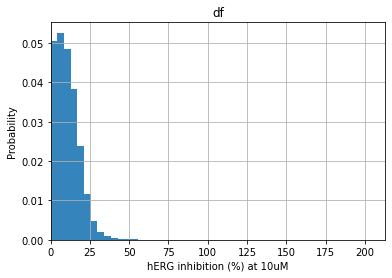

In [24]:
plot_pIC50(df, name='df', value ='hERG inhibition (%) at 10uM')

In [25]:
def calculate_pIC50(i):
    p = -np.log10(i/1000000000)
    return p

In [26]:
df["p_activity"] = df['hERG inhibition (%) at 10uM'].apply(calculate_pIC50)

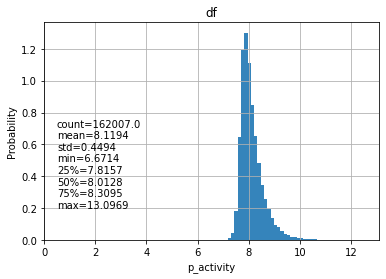

In [27]:
plot_pIC50(df, name='df', value ='p_activity')

In [28]:
df["MW"] = [Chem.Descriptors.MolWt(Chem.MolFromSmiles(m)) for m in df["SMILES"]] 

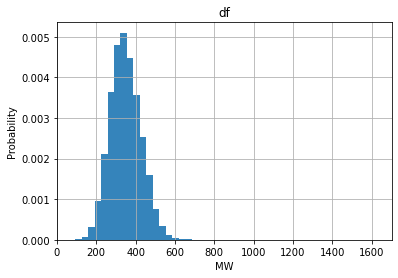

In [29]:
plot_pIC50(df, name='df', value ='MW')

In [29]:
def calc_morgan(mols):
    """ генерация молекулярных отпечатков по методу Моргана с радиусом 3
    """
    #t0 = time.time()
    for_df = []
    i=0
    for m in tqdm(mols):
        i+=1
        #t1 = time.time()
        #print("Processing compound {} ({}%)".format(i, 100*i//len(mols)), end="")
        arr = zeros((1,), dtype=int)
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(m, 3, 4096), arr)
        for_df.append(arr)
        #t2 = time.time()
        #print(" {}s (total: {}s)".format(t2-t1, t2-t0))
    return DataFrame(for_df)

In [19]:
df = calc_morgan(df["ROMol"])

100%|████████████████████████████████████████████████████████████████████████| 294939/294939 [01:18<00:00, 3753.61it/s]


MemoryError: 

Воспольуемся реализацией кластеризации по методу KNN  от  PatWalters https://github.com/PatWalters/kmeans
Параметры: fp = morgan3, dim = 2048, clusters = 500. 

In [31]:
#df1 = df[["SMILES", "class"]]
df1 = df
del df1["ROMol"]
df1 = df1[["SMILES", "PubChem Substance ID"]]
df1.to_csv("herg_central_class.smi", sep = " ", encoding='utf-8', index=False)

Теперь посмотрим, что получилось после кластеризации:

In [31]:
df_clust = pd.read_csv("herg_central_clusters.csv")

In [32]:
PandasTools.AddMoleculeColumnToFrame(df_clust,'SMILES','Mol')

In [33]:
len(df_clust)

162007

In [34]:
df_clust = df_clust.sort_values("Name")
df_clust.reset_index(drop=True, inplace=True)


In [36]:
df_clust = pd.concat([df_clust,df[["PubChem Substance ID", "hERG inhibition (%) at 10uM", "class"]]],axis=1)

,SMILES,Name,Cluster,Center,Mol,PubChem Substance ID,hERG inhibition (%) at 10uM,class
532,Cc1cc(C)n(CCOc2nonc2N)n1,843682,1,Yes,,843682,3.25098,0
858,CCOc1ccc2nc(NCCNC(=O)Nc3cccc(C)c3)c(C#N)cc2c1,844649,135,Yes,,844649,0.53658,0
1247,COCCN(CC(=O)NCc1ccccc1)C(=O)CCC(=O)Nc1nccs1,845840,139,Yes,,845840,6.81258,0
1754,Nc1nnc(CSCc2ccccc2)s1,847274,260,Yes,,847274,1.45598,0
1884,CC1CN(C(=O)c2cccc(C(=O)N3CC(C)OC(C)C3)c2)CC(C)O1,847640,415,Yes,,847640,19.10738,0
...,...,...,...,...,...,...,...,...
160765,COC(=O)C1=C(c2ccc(F)cc2OCc2ccccc2)C[C@@H]2CC[C...,81066021,301,Yes,,81066021,3.42108,0
160773,CCCNC(=O)N1[C@H]2CC[C@@H]1C(C(=O)OC)=C(c1ccc(C...,81066064,26,Yes,,81066064,4.58008,0
161326,COc1ccc(-c2sc3ccc(OC)cc3c2C#Cc2ccccn2)cc1,85146639,161,Yes,,85146639,13.48678,0
161420,COc1ccc(-c2c(-c3cc(OC)cc(OC)c3)n(C)c3ccc(-c4cc...,85146792,216,Yes,,85146792,12.32278,0

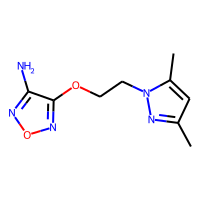
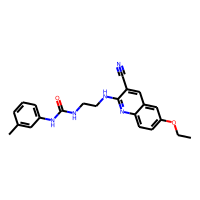
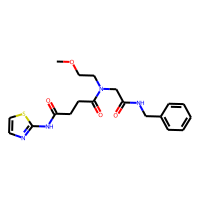
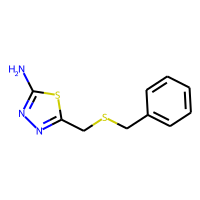
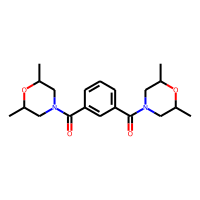
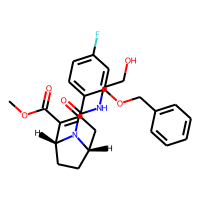
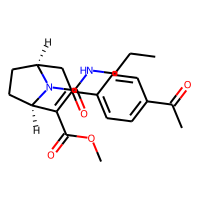
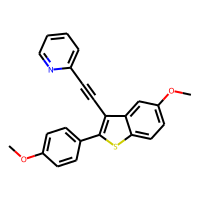
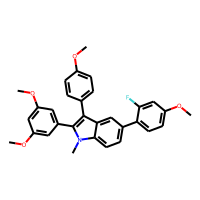
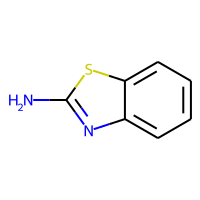

In [37]:
df_clust.loc[df_clust['Center'] == 'Yes'].head(497)

In [38]:
df_centres = df_clust.loc[df_clust['Center'] == 'Yes']
df_centres["class"].sum()

0

Проверим, что нумерация с df_mol точно совпадает и мы правильно проставили класс активности:

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM,class,ROMol,p_activity,MW
532,CC1=CC(=NN1CCOC2=NON=C2N)C,843682,5.6865,3.25098,0,,8.487986,223.236

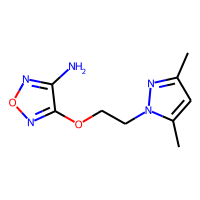

In [39]:
df_mol.loc[df_mol['PubChem Substance ID'] == 843682]

Проверим что у нас около 500 центров кластеризации:

In [40]:
df_clust["Center"].value_counts()

No     161507
Yes       500
Name: Center, dtype: int64

Построим гистограмму рапределения соединений по кластерам:

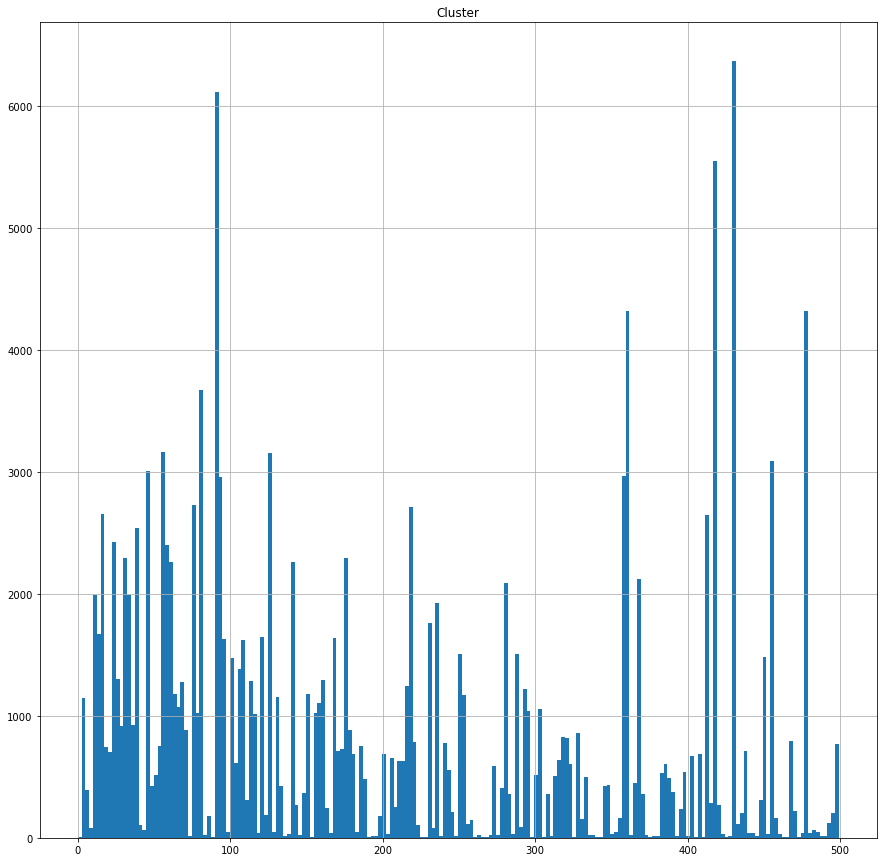

In [41]:
ax = df_clust.hist("Cluster",bins= 200,figsize=(15,15))

In [122]:
#p = ax.patches
#p[230].get_xy()

In [42]:
df_clust['Cluster'].value_counts()

430    5813
417    4705
360    3243
127    3153
90     3133
       ... 
304       1
126       1
339       1
211       1
411       1
Name: Cluster, Length: 500, dtype: int64

Самый большой кластер под номером 430, взглянем на его соединения:

,SMILES,Name,Cluster,Center,Mol,PubChem Substance ID,hERG inhibition (%) at 10uM,class
12,CN1C=CC2=C(C#N)C(N)C(C#N)(C#N)C(c3ccccc3)C2C1,842157,430,No,,842157,9.48638,0
64,CC(Sc1nc2ccccc2o1)C(=O)O,842324,430,No,,842324,7.39828,0
71,O=c1[nH]c(=O)n(CCO)c2nnn(Cc3ccccc3)c12,842335,430,No,,842335,12.96588,0
85,CCCc1[nH]nc2c1C(Cc1ccccc1)C(C#N)=C(N)O2,842368,430,No,,842368,0.43208,0
101,O=C(O)CCCC(=O)N1CC(=O)Nc2ccccc21,842434,430,No,,842434,4.49908,0
103,O=C1CC(c2ccco2)=Nc2ccccc2N1,842442,430,No,,842442,3.49728,0
115,C/C(CC1(O)C(=O)N(C)c2ccccc21)=N\O,842467,430,No,,842467,11.03138,0
117,O=C1Nc2ccccc2C12OCC1(CO2)COC2(OC1)C(=O)Nc1ccccc12,842469,430,No,,842469,8.14498,0
157,N#Cc1cccc2cnccc12,842587,430,No,,842587,4.95278,0
190,Cn1cccc1-c1cc(C(=O)O)[nH]n1,842676,430,No,,842676,17.90888,0

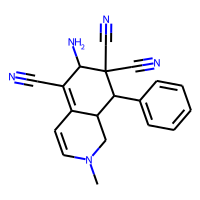
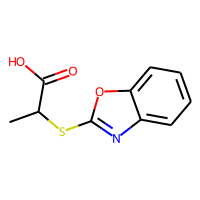
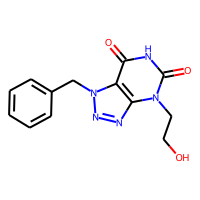
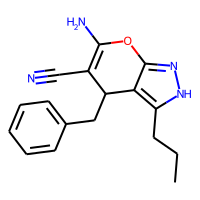
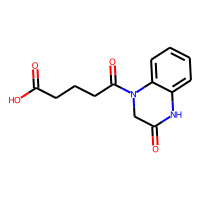
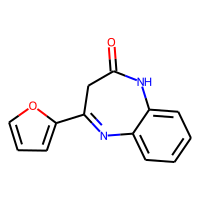
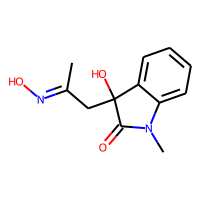
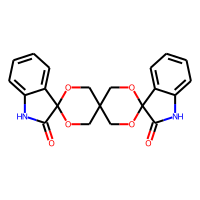
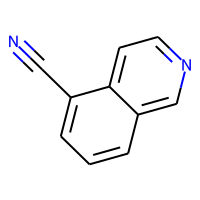
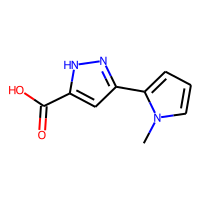
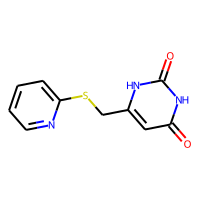
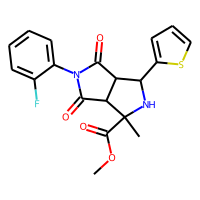
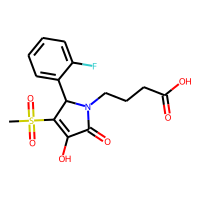
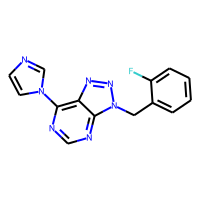
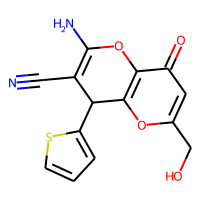

In [43]:
df_clust.loc[df_clust['Cluster'] == 430].head(15)

,SMILES,Name,Cluster,Center,Mol,PubChem Substance ID,hERG inhibition (%) at 10uM,class
143744,c1ccc2ccccc2c1,49816690,430,Yes,,49816690,20.91408,0

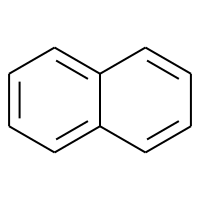

In [44]:
df_clust.loc[(df_clust['Cluster'] == 430) & (df_clust['Center'] == "Yes")]

Довольно разнородная выборка... И молекула, представляющая центр кластера - нафталин..

In [45]:
valid_set = pd.DataFrame(df_clust.drop_duplicates("Cluster"))
len(valid_set)

500

In [46]:
valid_set["class"].sum()

1

Таким образом, мы получили для валидации датасет, совершенно не содержащий активных молекул. Это плохой способ проверить модель.

Попробуем это исправить. Разделим всю выборку на блокаторы и неблокаторы, а далее из каждой выборки выберем одно соединений из каждого кластера.

In [47]:
unique_targets = df_clust['class'].unique()
target_dict = dict([(x,y) for x,y in zip(unique_targets,range(0,len(unique_targets)))])
num_targets = len(unique_targets)
target_dict

{0: 0, 1: 1}

In [48]:
mat = []
for k,v in df_clust.groupby("Cluster"):
    row_vec = np.zeros(num_targets,dtype=np.int8)
    for tgt,count in v['class'].value_counts().iteritems():
        tgt_idx = target_dict[tgt]
        row_vec[tgt_idx] = count
    mat.append(row_vec)
mat = np.array(mat)
out_df = pd.DataFrame(mat.transpose())
out_df.insert(0,"Class",unique_targets)
out_df

,Class,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,0,2,3,3,90,34,111,6,21,80,...,5,13,8,21,90,7,-58,-9,3,10
1,1,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,1,1,0,0


In [49]:
(out_df != 0).sum(axis=1)

0    500
1    106
dtype: int64

Таким образом, неактивные соединения присутствуют во всех кластерах. В то время, как активные лишь в 72 кластерах.
Разделим активные и неактивные соединения, а далее отберем по одному объекту из кажого кластера. 

In [50]:
def get_uniq_from_clust(df, activity):
    df = df[(df['class']==activity)]
    val_df = pd.DataFrame(df.drop_duplicates("Cluster"))
    return val_df

In [51]:
df_clust_active = get_uniq_from_clust(df = df_clust, activity = 1)
len(df_clust_active)

105

In [52]:
df_clust_inactive = get_uniq_from_clust(df = df_clust, activity = 0)
len(df_clust_inactive)

500

In [53]:
val_set = pd.concat([df_clust_active, df_clust_inactive])

In [54]:
len(val_set)

605

In [55]:
del val_set['Mol']

In [56]:
val_set.to_csv("herg_valid_set.csv", encoding='utf-8', index=False)

Вывод:
    В резултате мы получили валидационный сет для проверки модели, содержащий 105/500 (около 20 %) активных соединений и 500/600 (около 80%) неактивных соединений, причем каждое соединений в одном классе активности относится к разным кластерам (химически разнородны). 